# WindTurbineNoise

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import wave, struct
import scipy.signal as signal

# load some data from wav files
def wavLoad(fname,t1,dt):
    wf = wave.open(fname, 'rb')
    nframes=wf.getnframes()
    nsw=wf.getsampwidth()
    fs=wf.getframerate()
    nch=wf.getnchannels()
    nbuf=int(dt*fs)
    wf.setpos(int(t1*fs))
    buf=wf.readframes(nbuf)
    wf.close()
    data = np.array(struct.unpack('{n}h'.format(n=nbuf*nch),buf)).reshape(-1,nch)

    return data,fs,nch

fname='F:/WindTurbineNoise/5729.240323053619.wav'

data,fs,nch=wavLoad(fname,0,10)
print(data.shape)
dec=[5,5,4] # 200
xx=data
fsx=fs
for ii in range(len(dec)):
    xx=signal.decimate(xx,dec[ii],axis=0)
    fsx=fsx/dec[ii]

nw=1024
nover=nw//2
nfft=nw*4
f,t,Q = signal.stft(xx,fs=fsx,nperseg=nw,noverlap=nover,nfft=nfft, axis=0)
print(Q.shape)
L=10*np.log10(np.abs(Q))


(2880000, 4)
(2049, 4, 58)


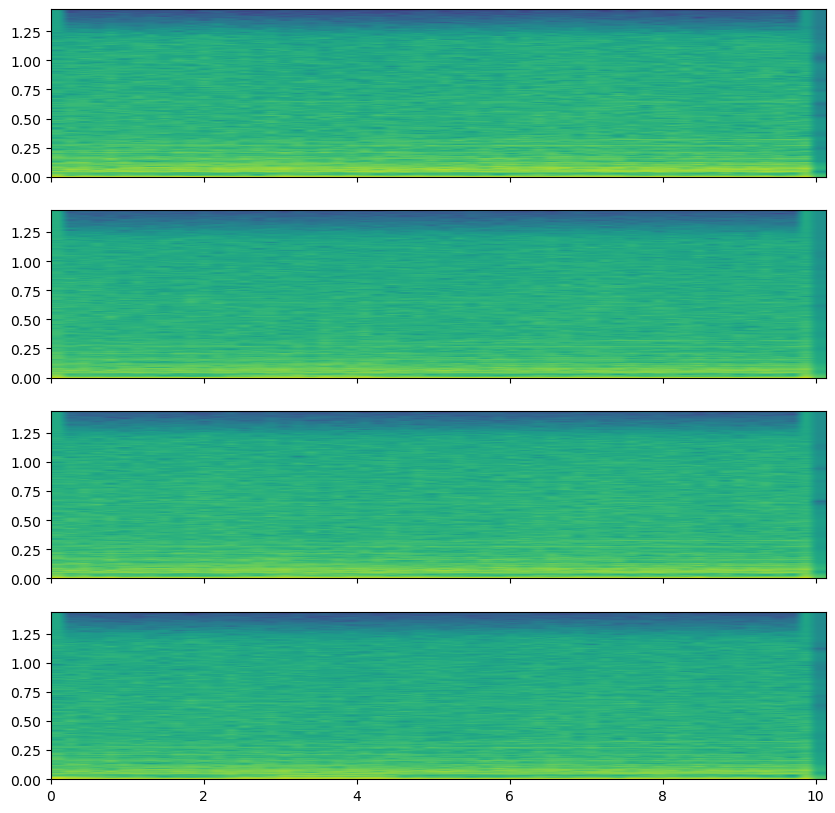

In [32]:
ext=[t[0],t[-1],f[0]/1000,f[-1]/1000]
fig, ax = plt.subplots(nch, 1, num=0, clear=True, sharex=True, figsize=(10,10))
for ii in range(nch):
    im=ax[ii].imshow(L[:,ii,:], origin='lower', aspect='auto',extent=ext)
plt.show()


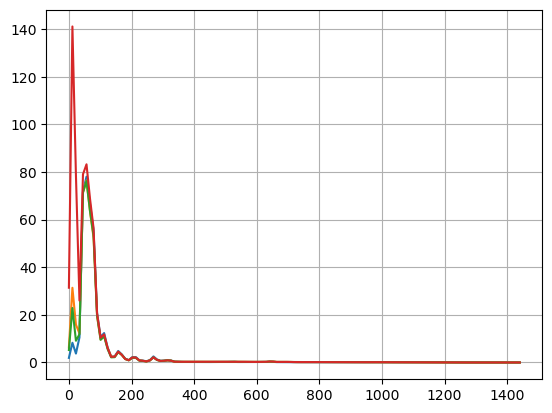

In [33]:
f,P=signal.welch(xx,fs=fsx,axis=0)
plt.plot(f,P)
#plt.semilogy(f,P)
plt.grid(True)
plt.show()

In [34]:
hsel=np.array([[1,0],[2,0],[3,0],[2,1],[3,1],[3,2]])    # hsel[:,1] is reference
#
# from Tripod_5729_xyz_config
#    ch1          0          0          0
#    ch2    -0.4028    -0.2208    -0.7069
#    ch3     0.0494     0.4548    -0.7069
#    ch4     0.4412    -0.2208    -0.7069
ho = np.array([[0,0,0],[-0.4028,    -0.2208,    -0.7069],[ 0.0494,     0.4548,    -0.7069],[0.4412,    -0.2208,    -0.7069]])
print(ho)
nc=hsel.shape[0]
D=ho[hsel[:,0],:]-ho[hsel[:,1],:]
L=np.sqrt(np.sum(D**2,1))
print(L,'m')
print(0.75/L, 'kHz')
DI=np.linalg.pinv(D)
Lm=np.max(L)
print(Lm)

[[ 0.      0.      0.    ]
 [-0.4028 -0.2208 -0.7069]
 [ 0.0494  0.4548 -0.7069]
 [ 0.4412 -0.2208 -0.7069]]
[0.84303505 0.84201604 0.86204274 0.81296999 0.844      0.78098822] m
[0.88964273 0.89071937 0.87002647 0.92254328 0.88862559 0.96032178] kHz
0.8620427425597874


In [35]:

def getIntensity(xx,fs,nw,nfft):
    f,t,Q=signal.stft(xx,fs=fs,nperseg=nw,noverlap=nw//2,nfft=nfft,axis=0)
    Q=Q.transpose(0,2,1)
    C = -np.imag(Q[:,:,hsel[:,0]]*np.conjugate(Q[:,:,hsel[:,1]]))
    I = -C@DI.T
    return f,t,I

f,t,I = getIntensity(xx,fsx,nw,nfft)

I[ 0,:,:]=I[ 1,0,0]
I[-1,:,:]=I[-2,0,0]
#
fo=f.copy()
f[0]=f[1]
for ii in range(3):
    I[:,:,ii] /= f.reshape(-1,1)
f=fo.copy()
#
In=np.sqrt(np.sum(I**2,2))
K= I/In.reshape(In.shape[0],In.shape[1],1)


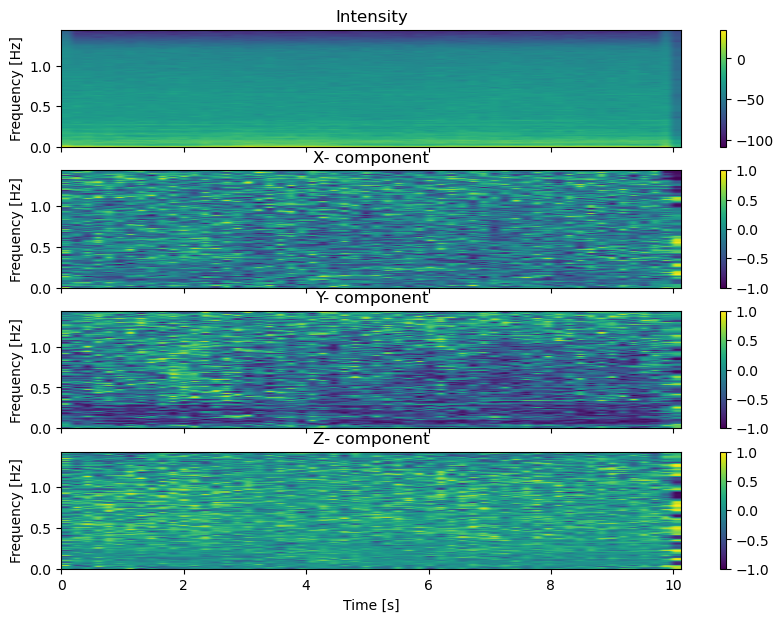

In [36]:
nc=hsel.shape[0]
fig, ax = plt.subplots(4, 1, num=0, clear=True, sharex=True, figsize=(10,7))
im=ax[0].imshow(10*np.log10(In), origin='lower', aspect='auto',extent=ext)
plt.colorbar(im)
ax[0].set_title('Intensity')
ax[0].set_ylabel('Frequency [Hz]')

ylabels=['X','Y','Z']
for ii in range(3):
    im=ax[1+ii].imshow(K[:,:,ii],origin='lower', aspect='auto',extent=ext,clim=[-1,1])
    ax[1+ii].set_title(ylabels[ii]+'- component')
    ax[1+ii].set_ylabel('Frequency [Hz]')
    plt.colorbar(im)
ax[3].set_xlabel('Time [s]')
plt.show()


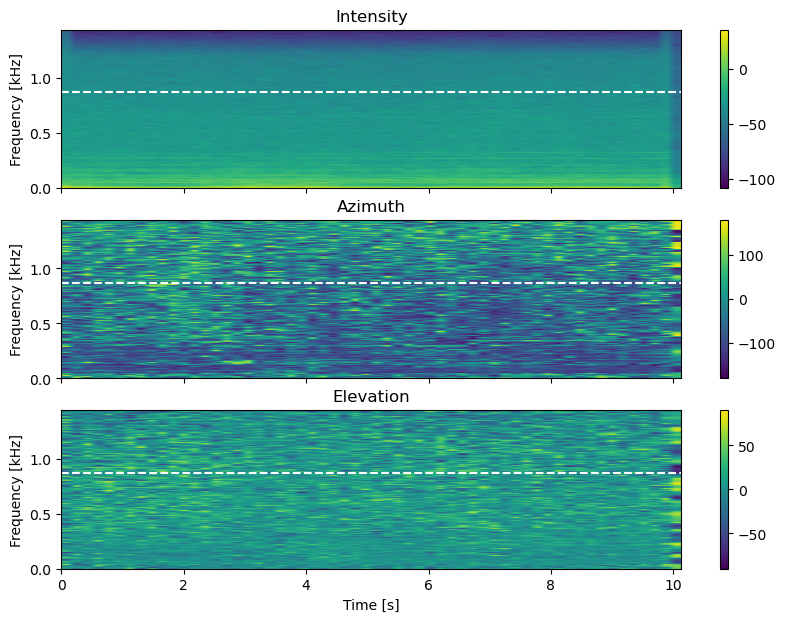

In [37]:
## angle estimations
Azx=180/np.pi*np.arctan2(I[:,:,1],I[:,:,0])
Elx=180/np.pi*np.arctan2(I[:,:,2],np.sqrt(I[:,:,0]**2+I[:,:,1]**2))
#
fig, ax = plt.subplots(3, 1, num=0, clear=True, sharex=True, figsize=(10,7))
im=ax[0].imshow(10*np.log10(In), origin='lower', aspect='auto',extent=ext)
ax[0].hlines(0.75/Lm,t[0],t[-1],colors='w',linestyles='--')
ax[0].set_ylabel('Frequency [kHz]')
ax[0].set_title('Intensity')
plt.colorbar(im)
#
im=ax[1].imshow(Azx,origin='lower', aspect='auto',extent=ext,clim=(-180,180))
ax[1].hlines(0.75/Lm,t[0],t[-1],colors='w',linestyles='--')
ax[1].set_ylabel('Frequency [kHz]')
ax[1].set_title('Azimuth')
plt.colorbar(im)
#
im=ax[2].imshow(Elx,origin='lower', aspect='auto',extent=ext,clim=(-90,90))
ax[2].hlines(0.75/Lm,t[0],t[-1],colors='w',linestyles='--')
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Frequency [kHz]')
ax[2].set_title('Elevation')
plt.colorbar(im)
#
plt.show()



71 142


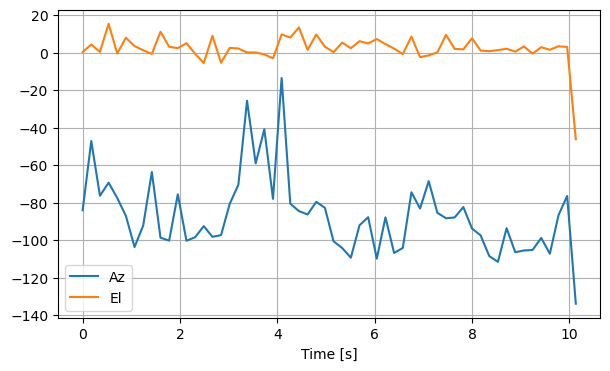

In [47]:
k1=int(50/fsx*nfft)
k2=int(100/fsx*nfft)
print(k1,k2)
Aze=np.mean(Azx[k1:k2,:],axis=0)
Ele=np.mean(Elx[k1:k2,:],axis=0)
#
#
plt.figure(figsize=(7,4))
plt.plot(t,Aze,label='Az')
plt.plot(t,Ele,label='El')
plt.xlabel('Time [s]')
plt.grid(True)
plt.legend()
plt.show()

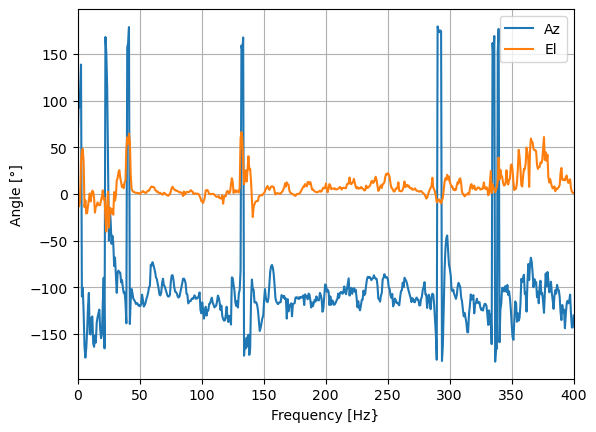

In [49]:
J=np.median(I,1)
## angle estimations
Azm=180/np.pi*np.arctan2(J[:,1],J[:,0])
Elm=180/np.pi*np.arctan2(J[:,2],np.sqrt(J[:,0]**2+J[:,1]**2))
plt.plot(f,Azm,label='Az')
plt.plot(f,Elm,label='El')
plt.vlines(750/Lm,-180,180,colors='k',linestyles='--')
plt.xlabel('Frequency [Hz}')
plt.ylabel('Angle [°]')
plt.grid(True)
plt.xlim(0,400)
plt.legend()
plt.show()